<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Извлекаем-леммы" data-toc-modified-id="Извлекаем-леммы-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Извлекаем леммы</a></span></li><li><span><a href="#Train-test" data-toc-modified-id="Train-test-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train test</a></span></li><li><span><a href="#Подготовка-к-обучению" data-toc-modified-id="Подготовка-к-обучению-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подготовка к обучению</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Бизнес идея: Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. 

Бизнес задача: Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицирующую комментарии на позитивные и негативные.

## Подготовка

### Import

In [12]:
#!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

pd.set_option('display.max_columns', None)

In [14]:
try:
    data = pd.read_csv("d:/Temp/toxic_comments.csv")
    
except FileNotFoundError:
    data = pd.read_csv("/datasets/toxic_comments.csv")

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [16]:
data.sample(20)

,text,toxic
132208,"""\n Not in the material I've read (PSB), or I'...",0
37297,I will blank out my entire user page. I should...,0
73531,what gives? heard of racism? how about class...,0
31679,"well that's just peachy, now go do something e...",0
32650,book warhead exploded a metre away independent...,0
75722,Sources \n\nGiven the increased probability th...,0
47720,"Ok, for the mitochondrion you might want to wa...",0
96380,I've heard that a lemon is also a Russian term...,0
4263,Link to Wikimedia commons,0
97943,"""\n\nAlso while I'm thinking about it: In all ...",0


In [17]:
data.isnull().mean()

text     0.0
toxic    0.0
dtype: float64

In [18]:
# количество токсичных правок в датасете
data['toxic'].mean().round(2)

0.1

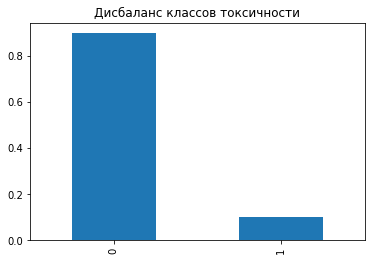

In [19]:
pd.Series(data['toxic'].value_counts() / len(data)).plot(kind='bar', title='Дисбаланс классов токсичности');

Присуствует дисбаланс классов.

### Извлекаем леммы

In [20]:
# Лемматизация через WordNetLemmatizer

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# Функция лемматизации к каждому слову, очистка текста от лишних символов

In [23]:
def lemm_clear_text(text):
    string = re.sub(r'[^a-zA-Z]', ' ', text)
    string = ' '.join(string.split()).lower()
    
    lemmatizer = WordNetLemmatizer()
           
    return " ".join([lemmatizer.lemmatize(word) for word in string.split()])

In [24]:
features = data['lemm_text'] = data['text'].apply(lemm_clear_text)
target = data['toxic']

Как видно из корпуса, лемматизация корректно не отработала сокращенные формы, но для определения токсичности это не важно, из за того что в сокращенную форму попадает временная составляющая глагола, отрицательная форма, и принадлежность к личности например I'm = i am. 

Для токсичности это не имеет значения, так это корректная форма текста, и никак не повлияет на токсичные выражения.

### Train test

In [25]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=12345)

In [26]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(features_train.values)
tf_idf_train

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<119678x134110 sparse matrix of type '<class 'numpy.float64'>'
	with 3254925 stored elements in Compressed Sparse Row format>

In [27]:
tf_idf_test = count_tf_idf.transform(features_test.values)
tf_idf_test

<39893x134110 sparse matrix of type '<class 'numpy.float64'>'
	with 1047914 stored elements in Compressed Sparse Row format>

### Подготовка к обучению

In [28]:
scoring=make_scorer(f1_score)

## Обучение

### LogisticRegression

In [29]:
model = LogisticRegression(random_state=12345, class_weight='balanced', n_jobs=-1)
model.fit(tf_idf_train, target_train)
predict_test = model.predict(tf_idf_test)
print('F1_score =', f1_score(target_test, predict_test))

F1_score = 0.7500803427959294


### DecisionTreeClassifier

In [30]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(tf_idf_train, target_train)
predict_test = model.predict(tf_idf_test)
print('F1_score =', f1_score(target_test, predict_test))

F1_score = 0.6507315983469227


### RandomForestClassifier

In [31]:
model = RandomForestClassifier(random_state=12345, n_jobs=-1, class_weight='balanced')
model.fit(tf_idf_train, target_train)
predict_test = model.predict(tf_idf_test)
print('F1_score =', f1_score(target_test, predict_test))

F1_score = 0.608724171859626


### CatBoostClassifier

In [32]:
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

model = CatBoostClassifier(loss_function='Logloss',
                           verbose=0,
                           learning_rate=0.2,
                           iterations=300,
                           class_weights=weights,
                           random_state=12345)
model.fit(tf_idf_train, target_train)
predict_test = model.predict(tf_idf_test)
print('F1_score =', f1_score(target_test, predict_test))

F1_score = 0.7443037974683544


## Выводы

В результате обучения модель LogisticRegression показала лучший результат метрики 0.75, с учетом баланса весов. CatBoostClassifier так же дожала метрику до необходимого порога, но временные затраты слишком велики.

Векторизацию данных проводил через оценку важности слова (TF-IDF), так как она более точна чем мешок слов, но и менее точна чем BERT.